In [2]:
import sys

sys.path.append('/Users/robertwelch/Desktop/BIIF/Chiara3/Federico-Pietrocola2022-3/src')

from senolysis_analysis import *
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import regionprops, label

In [3]:
def plot_multi(img_list):

    if isinstance(img_list,list):
        n = len(img_list)

        fig,ax = plt.subplots(1,n)
        fig.set_size_inches(15,15)

        for i,img in enumerate(img_list):
            ax[i].imshow(img,cmap='gray')
    else:
        raise Exception('Input is not a list of images')


In [133]:
def find_intensities(mask,red_downscaled,green_downscaled,blue_downscaled):

    nuclei_scenenst = regionprops(label(mask),intensity_image=red_downscaled)
    nuclei_quiescent = regionprops(label(mask),intensity_image=green_downscaled)
    nuclei_regions = regionprops(label(mask),intensity_image=blue_downscaled)

    red_intensities = []
    green_intensities = []
    nuclei_intentisies = []
    nuclei_size = []
    for i in range(len(nuclei_quiescent)):
        red_intensities.append(nuclei_scenenst[i].mean_intensity)
        green_intensities.append(nuclei_quiescent[i].mean_intensity)
        nuclei_intentisies.append(nuclei_regions[i].mean_intensity)
        nuclei_size.append(nuclei_regions[i].area)



    red_intensities = np.array(red_intensities)
    green_intensities = np.array(green_intensities)

    X = np.zeros([len(green_intensities),4])
    X[:,0] = red_intensities
    X[:,1] = green_intensities
    X[:,2] = nuclei_intentisies
    X[:,3] = nuclei_size
    
    #Normalize for each image
    #X = X/X.max(axis=0)

    return X

def remove_well_rings(img,max_size = 150):
        from skimage.filters import threshold_mean
        from skimage.morphology import binary_dilation,disk
        from skimage.segmentation import flood_fill


        thresh = threshold_mean(img)
        binary = img > thresh
        regions = regionprops(label(binary))
        # Generate mask of regions below max_size
        removal_mask = np.zeros(img.shape, dtype="bool")
        for region in regions:
            if max_size < region.area:
                removal_mask[tuple(region.coords.T.tolist())] = 1

        #Dilate slightly to ensure well-edge is completely removed
        removal_mask = binary_dilation(removal_mask,disk(15))

        #fill corners of image (Outside of well)
        removal_mask = flood_fill(removal_mask, (0, 0), 1)
        removal_mask = flood_fill(removal_mask, (-1, 0), 1)
        removal_mask = flood_fill(removal_mask, (0, -1), 1)
        removal_mask = flood_fill(removal_mask, (-1, -1), 1)

        #invert mask
        removal_mask = np.abs(removal_mask-1)

        out = removal_mask * img
        return out, removal_mask

In [135]:
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/EmissionFilterCorrected/Senolysis images 8.11.22/WellB10_ChannelSenolysis Hoechst,Senolysis,Senolysis EGFP_Seq0048.nd2'
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/EmissionFilterCorrected/Senolysis images 8.11.22/WellB08_ChannelSenolysis Hoechst,Senolysis,Senolysis EGFP_Seq0036.nd2'
img_path = '/Users/robertwelch/Desktop/BIIF/Chiara3/EmissionFilterCorrected/Senolysis images 8.11.22/WellB10_ChannelSenolysis Hoechst,Senolysis,Senolysis EGFP_Seq0048.nd2'
#def main(img_path):
    
red, green, blue = nd2_import(img_path)

downscale_factor = 4
blue_downscaled = downscale_local_mean(
    blue, factors=(downscale_factor, downscale_factor)
)
green_downscaled = downscale_local_mean(
    green, factors=(downscale_factor, downscale_factor)
)
red_downscaled = downscale_local_mean(
    red, factors=(downscale_factor, downscale_factor)
)

# normalize to [0,1] for 0 to 99th percentiles
red_norm, green_norm, blue_norm = (
    normalize_img(red_downscaled, high_per=98),
    normalize_img(green_downscaled, high_per=98),
    normalize_img(blue_downscaled, high_per=98),
)

# downscale the images for faster computation @300ms each


# Smooth the blue channel for nuclei segmentation
blue_smoothed = gaussian(blue_norm, 1)  # smooth image

# remove the well ring from the blue channel
blue_no_well_ring, removal_mask = remove_well_rings(blue_smoothed)

nuclei_thresholded = threshold_with_otsu(blue_no_well_ring)
nuclei_thresholded_upscaled = remove_small_objects(nuclei_thresholded,min_size=50)
nuclei_thresholded_upscaled = remove_large_nuclei(nuclei_thresholded,1000)
nuclei_thresholded_upscaled = resize(nuclei_thresholded, output_shape=blue.shape)



# Determine if each nuclei belongs to scenescent or quiescent cell #500ms

def classify_nuclei(mask, red, green):

    nuclei_regions = regionprops(label(mask))

    scenescent = np.zeros(mask.shape)
    quiescent = np.zeros(mask.shape)
    for nuclei in nuclei_regions:
        nuclei_coordinates = nuclei.coords
        red_value = np.mean(red[tuple(nuclei_coordinates.T)])
        green_value = np.mean(green[tuple(nuclei_coordinates.T)])

        if red_value > green_value:
            scenescent[tuple(nuclei_coordinates.T)] = 1
        else:
            quiescent[tuple(nuclei_coordinates.T)] = 1

    return np.bool_(scenescent), np.bool_(quiescent)

scenescent_downscaled, quiescent_downscaled = classify_nuclei(
    mask=nuclei_thresholded,
    red=red_norm,
    green=green_norm,
)

# Upsample segmentation results back to orignal image size #800ms each
scenescent_upscaled = resize(scenescent_downscaled, output_shape=blue.shape)
quiescent_upscaled = resize(quiescent_downscaled, output_shape=blue.shape)


# Measures counts and nuclei mean size + std
results_dataframe = analyze_nuclei(
    scenescent_upscaled, quiescent_upscaled, img_path
)

#     # X_norm = find_intensities(nuclei_thresholded,red_downscaled,green_downscaled,blue_downscaled)
#     # X = find_intensities(nuclei_thresholded_upscaled,red,green,blue)

#     # return X_norm, X



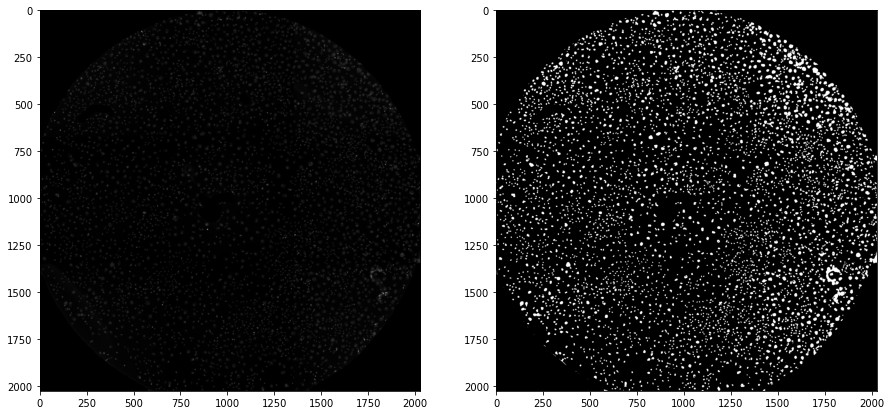

In [136]:
plot_multi([blue_no_well_ring,nuclei_thresholded])

In [132]:
#kmeans = KMeans(n_clusters=5, random_state=0).fit(all_X[:,:1])


x = np.linspace(0,1,50)
y = x

X_color_01 = X/X.max(axis=0) # have to normalize colours
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Real Color')
plt.scatter(X[:,0],X[:,1],c = X_color_01[:,:3])
plt.plot(x,y)

plt.ylabel('green Intensities')
plt.xlabel('red Intensities')

plt.subplot(1,2,2)
plt.title('Rea Color')
plt.scatter(X_norm[:,0],X_norm[:,1],c=X_norm[:,:3])
plt.plot(x,y)
plt.ylabel('green Intensities')
plt.xlabel('red Intensities')

NameError: name 'X' is not defined